## EDA

In [13]:
import pandas as pd
import re
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
content = pd.read_csv('Data/XYZ_NETWORKS_ONLINE_CONTENT_CONSUMPTION.csv')
sub_1p = pd.read_csv('Data/XYZ_NETWORKS_SUB_1P_DATA.csv')
view1 = pd.read_csv('Data/XYZ_NETWORKS_VIEWERSHIP_DATA_1.csv')
view2 = pd.read_csv('Data/XYZ_NETWORKS_VIEWERSHIP_DATA_2.csv')
view3 = pd.read_csv('Data/XYZ_NETWORKS_VIEWERSHIP_DATA_3.csv')

In [5]:
def percentage_na(df, column_name):
    """
    This function returns the percentage of missing (NaN) values in a specified column of a pandas DataFrame.
    
    Parameters:
    df (pd.DataFrame): The pandas DataFrame
    column_name (str): The column name to check for missing values
    
    Returns:
    float: The percentage of missing values in the specified column
    """
    if column_name in df.columns:
        total_rows = len(df)
        na_count = df[column_name].isna().sum()
        na_percentage = (na_count / total_rows) * 100
        return na_percentage
    else:
        raise ValueError(f"Column '{column_name}' not found in the DataFrame.")


def count_unique_values(df, column_name):
    """
    This function returns the number of unique values in a specified column of a pandas DataFrame.
    
    Parameters:
    df (pd.DataFrame): The pandas DataFrame
    column_name (str): The column name to check for unique values
    
    Returns:
    int: The number of unique values in the specified column
    """
    if column_name in df.columns:
        return df[column_name].nunique()
    else:
        raise ValueError(f"Column '{column_name}' not found in the DataFrame.")

def plot_histogram(df, column_name, bins=10):
    """
    This function plots a histogram of a specified column in a pandas DataFrame.
    
    Parameters:
    df (pd.DataFrame): The pandas DataFrame
    column_name (str): The column name to plot the histogram for
    bins (int): The number of bins for the histogram (default is 10)
    
    Returns:
    None
    """
    if column_name in df.columns:
        plt.figure(figsize=(8, 6))
        plt.hist(df[column_name].dropna(), bins=bins, edgecolor='black', alpha=0.7)
        plt.title(f'Histogram of {column_name}')
        plt.xlabel(column_name)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()
    else:
        raise ValueError(f"Column '{column_name}' not found in the DataFrame.")


### Feature Engineering for Viewership Data

#### Data Cleaning

In [18]:
# combine the three viewership data
combined_view = pd.concat([view1, view2, view3], axis=0, ignore_index=True)

## remove nas and impute nas
view_cleaned = combined_view.dropna(subset=['ID', 'NETWORK', 'PROGRAM_NAME', 'EVENT_START_TIMESTAMP', 'DURATION_SECONDS'])
view_cleaned['GENRE'] = view_cleaned['GENRE'].fillna('Other')

## filter DURATION_SECONDS >= 360
view_filtered = view_cleaned[view_cleaned['DURATION_SECONDS'] >= 360]

#### Add new features

In [19]:
linear_networks = ['LimeLight', 'Pulse', 'ChillStream', 'RetroReel', 'CineQuest']
fast_networks = ['Adrenaline', 'DarkMatter', 'SilverScreen Classics', 
                 'TimeCapsule TV', 'TasteMakers', 'DesignLab', 'PopCulture Now']

def get_network_type(network):
    """
    Return 'PAID' if the network is in the paid_networks list, else 'UNPAID'.
    
    Parameters:
    network (str): The network name to check.
    paid_networks (list): List of paid networks.

    Returns:
    str: 'PAID' if the network is in paid_networks, else 'UNPAID'.
    """
    if network in linear_networks:
        return 'LINEAR'
    elif network in fast_networks:
        return 'FAST'
    else:
        return 'REAL'

view_filtered['NETWORK_TYPE'] = view_filtered['NETWORK'].apply(get_network_type)
view_filtered = view_filtered[view_filtered['NETWORK_TYPE'] != 'REAL']

view_filtered['DURATION_MINUTES'] = view_filtered['DURATION_SECONDS'] / 60
view_filtered['DURATION_MINUTES'] = view_filtered['DURATION_MINUTES'].round(1)
view_filtered['AD_REVENUE'] = (0.25/3600)*view_filtered['DURATION_SECONDS']
view_filtered.drop(columns='DURATION_SECONDS', inplace=True)

# Convert 'EVENT_START_TIMESTAMP' to datetime
view_filtered['EVENT_START_TIMESTAMP'] = pd.to_datetime(view_filtered['EVENT_START_TIMESTAMP'], utc = False)

In [20]:
def localize(x):
    return x.tz_localize(None)

view_filtered['EVENT_START_TIMESTAMP'] = view_filtered['EVENT_START_TIMESTAMP'].apply(localize)

# Create new columns for weekday and hour
view_filtered['WEEKDAY'] = view_filtered['EVENT_START_TIMESTAMP'].dt.day_name()
view_filtered['HOUR'] = view_filtered['EVENT_START_TIMESTAMP'].dt.hour
view_filtered['YEAR'] = view_filtered['EVENT_START_TIMESTAMP'].dt.year
view_filtered['MONTH'] = view_filtered['EVENT_START_TIMESTAMP'].dt.month

In [22]:
train_start, train_end = '2022-01-01','2022-12-31'
train_y_start, train_y_end = '2023-01-01','2023-06-30'

test_start, test_end = '2022-06-01','2023-06-30'
test_y_start, test_y_end = '2023-07-01','2023-12-31'

predict_start, predict_end ='2023-01-01','2023-12-31'

train_X = view_filtered[(view_filtered['EVENT_START_TIMESTAMP'] >= train_start) & (view_filtered['EVENT_START_TIMESTAMP'] <= train_end)]
test_X = view_filtered[(view_filtered['EVENT_START_TIMESTAMP'] >= test_start) & (view_filtered['EVENT_START_TIMESTAMP'] <= test_end)]
predict_X = view_filtered[(view_filtered['EVENT_START_TIMESTAMP'] >= predict_start) & (view_filtered['EVENT_START_TIMESTAMP'] <= predict_end)]

train_y = view_filtered[(view_filtered['EVENT_START_TIMESTAMP'] >= train_y_start) & (view_filtered['EVENT_START_TIMESTAMP'] <= train_y_end)]
test_y = view_filtered[(view_filtered['EVENT_START_TIMESTAMP'] >= test_y_start) & (view_filtered['EVENT_START_TIMESTAMP'] <= test_y_end)]

In [29]:
def groupby_df(df, current_day):
    current_day = pd.to_datetime(current_day)
    
    # Group by ID and find the last watch date
    df_last_watch = df.groupby(['ID', 'NETWORK'])['EVENT_START_TIMESTAMP'].max().reset_index()
    df_last_watch['DAYS_AFTER_LAST_WATCH'] = (current_day - df_last_watch['EVENT_START_TIMESTAMP']).dt.days
    df_last_watch = df_last_watch.drop(columns=['EVENT_START_TIMESTAMP'])
    
    # Group by ID and find the first watch date
    df_first_watch = df.groupby(['ID', 'NETWORK'])['EVENT_START_TIMESTAMP'].min().reset_index()
    df_first_watch['DAYS_AFTER_FIRST_WATCH'] = (current_day - df_first_watch['EVENT_START_TIMESTAMP']).dt.days
    df_first_watch = df_first_watch.drop(columns=['EVENT_START_TIMESTAMP'])
    
    # Group by ID to find the unique networks watched
    df_unique_watch = df.groupby(['ID', 'NETWORK'])[['GENRE', 'PROGRAM_NAME']].nunique().reset_index()
    df_unique_watch.columns = ['ID', 'NETWORK', 'UNIQUE_GENRES_WATCHED', 'UNIQUE_PROGRAMS_WATCHED']
    
    # Group by ID to find the mean duration in minutes
    df_mean_duration = df.groupby(['ID', 'NETWORK'])['DURATION_MINUTES'].mean().round(2).reset_index()
    df_mean_duration.columns = ['ID', 'NETWORK', 'MEAN_DURATION_MINUTES']
    
    # Group by ID to find the sum of ad revenue in minutes
    df_sum = df.groupby(['ID', 'NETWORK'])[['DURATION_MINUTES', 'AD_REVENUE']].sum().round(2).reset_index()
    df_sum.columns = ['ID', 'NETWORK', 'SUM_DURATION_MINUTES', 'SUM_AD_REVENUE']
    
    # Group by ID to find the number of rows (sessions) as NUM_SESSIONS
    df_num_sessions = df.groupby(['ID', 'NETWORK']).size().reset_index(name='NUM_SESSIONS')
    
    # Merge all data into a final DataFrame
    df_final = pd.merge(df_last_watch, df_first_watch, on=['ID', 'NETWORK'])
    df_final = pd.merge(df_final, df_num_sessions, on=['ID', 'NETWORK'])
    df_final = pd.merge(df_final, df_unique_watch, on=['ID', 'NETWORK'])
    df_final = pd.merge(df_final, df_mean_duration, on=['ID', 'NETWORK'])
    df_final = pd.merge(df_final, df_sum, on=['ID', 'NETWORK'])

    return df_final

In [30]:
train_X_final = groupby_df(train_X, train_end)
test_X_final = groupby_df(test_X, test_end)
predict_X_final = groupby_df(predict_X, predict_end)

train_y_final = groupby_df(train_y, train_y_end)
test_y_final = groupby_df(test_y, test_y_end)

In [27]:
train_X_final.to_csv('view_train_X.csv', index=False)
test_X_final.to_csv('view_test_X.csv', index=False)
predict_X_final.to_csv('view_predict_X.csv', index=False)

train_y_final.to_csv('view_train_y.csv', index=False)
test_y_final.to_csv('view_test_y.csv', index=False)

### EDA

In [32]:
len(train_X_final), len(train_y_final)


(62878, 37804)

In [35]:
train_X_final

,ID,NETWORK,DAYS_AFTER_LAST_WATCH,DAYS_AFTER_FIRST_WATCH,NUM_SESSIONS,UNIQUE_GENRES_WATCHED,UNIQUE_PROGRAMS_WATCHED,MEAN_DURATION_MINUTES,SUM_DURATION_MINUTES,SUM_AD_REVENUE
0,000AHHU956,RetroReel,218,218,1,1,1,16.8,16.8,0.07
1,000AUEW012,Adrenaline,185,185,1,1,1,81.1,81.1,0.34
2,000AZAF724,Adrenaline,7,7,1,1,1,43.4,43.4,0.18
3,000AZAF724,DarkMatter,194,194,1,1,1,10.3,10.3,0.04
4,000BRHY264,CineQuest,8,8,1,1,1,97.3,97.3,0.41
...,...,...,...,...,...,...,...,...,...,...
62873,999XNOX153,PopCulture Now,150,150,1,1,1,18.5,18.5,0.08
62874,999YDIA746,Adrenaline,18,18,1,1,1,85.1,85.1,0.35
62875,999YJJT120,DarkMatter,90,90,1,1,1,34.5,34.5,0.14
62876,999ZIAU985,RetroReel,147,341,2,1,2,92.5,185.0,0.77


In [36]:
train_X['GENRE'].value_counts().head(50)

Other                          35871
Extreme Sports                  7434
Classic films                   4135
Original Films                  2909
Reality-TV, Lifestyle           2541
Lifestyle, Entertainment        2471
Action                          2288
Original Scripted Series        2238
Documentary, Nature             2053
Reality-TV                      1760
TV shows                        1405
Adventure                       1105
Action, Adventure, Thriller     1100
Documentary                      964
Nature                           960
Lifestyle                        839
Entertainment                    830
Action, Adventure                584
Thriller                         578
Documentary, Travel              496
Nature, Travel                   477
Name: GENRE, dtype: int64

In [37]:
# Filter for rows where both IS_PAID_NETWORK and IS_FAST_NETWORK are False
train_X[(train_X['NETWORK_TYPE'] == 'FAST')]['NETWORK'].unique()

# no 'SilverScreen Classics', and 'TimeCapsule TV'

array(['TasteMakers', 'PopCulture Now', 'DarkMatter', 'DesignLab',
       'Adrenaline'], dtype=object)

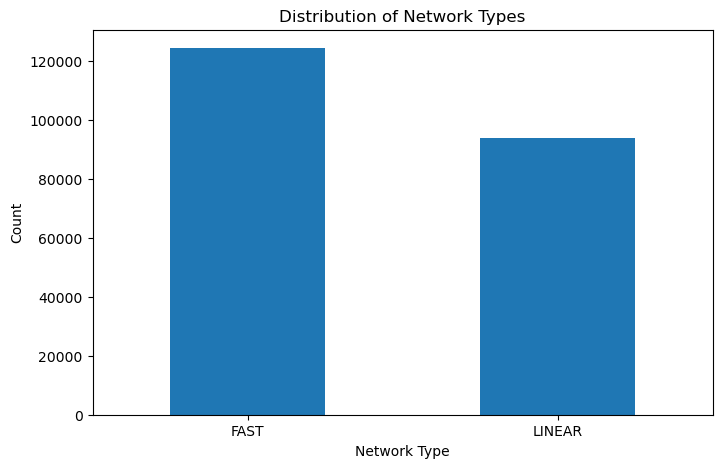

In [444]:
plt.figure(figsize=(8, 5))
view_xyz['NETWORK_TYPE'].value_counts().plot(kind='bar')

# Customize the plot
plt.title('Distribution of Network Types')
plt.xlabel('Network Type')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Show the plot
plt.show()

In [446]:
# Calculate the average DURATION_SECONDS for each NETWORK_TYPE
avg_duration = view_xyz.groupby('NETWORK_TYPE')['DURATION_MINUTES'].mean()
avg_duration

NETWORK_TYPE
FAST      55.447239
LINEAR    65.642743
Name: DURATION_MINUTES, dtype: float64

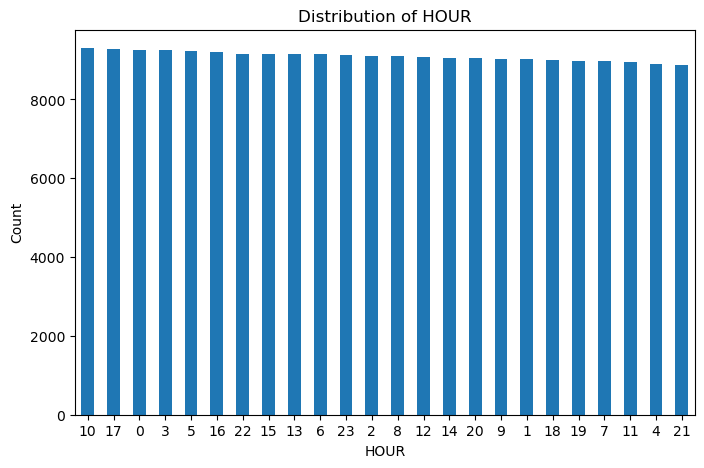

In [448]:
plt.figure(figsize=(8, 5))
view_xyz['HOUR'].value_counts().plot(kind='bar')

# Customize the plot
plt.title('Distribution of HOUR')
plt.xlabel('HOUR')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Show the plot
plt.show()

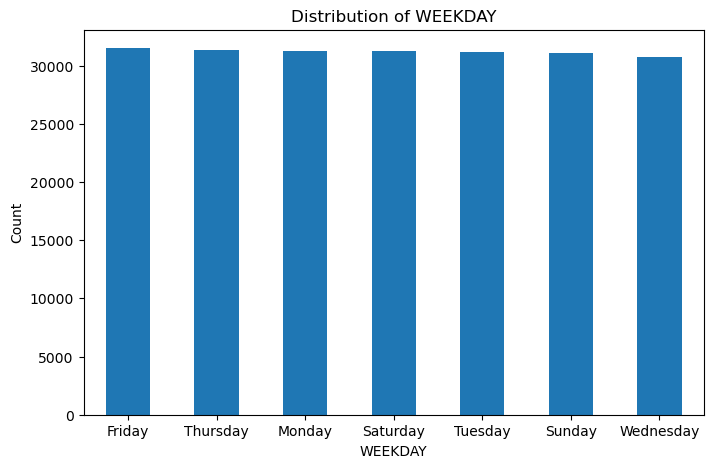

In [450]:
plt.figure(figsize=(8, 5))
view_xyz['WEEKDAY'].value_counts().plot(kind='bar')

# Customize the plot
plt.title('Distribution of WEEKDAY')
plt.xlabel('WEEKDAY')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Show the plot
plt.show()

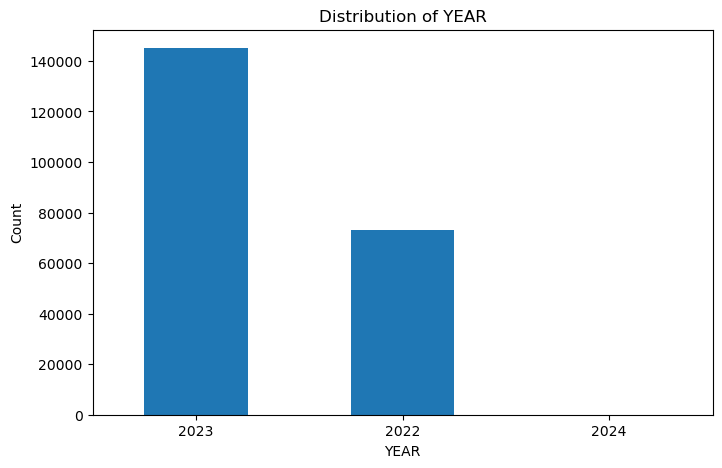

In [452]:
plt.figure(figsize=(8, 5))
view_xyz['YEAR'].value_counts().plot(kind='bar')

# Customize the plot
plt.title('Distribution of YEAR')
plt.xlabel('YEAR')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Show the plot
plt.show()

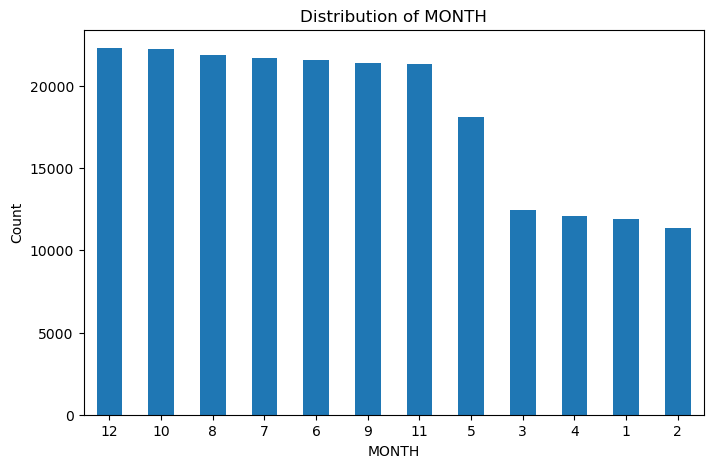

In [454]:
plt.figure(figsize=(8, 5))
view_xyz['MONTH'].value_counts().plot(kind='bar')

# Customize the plot
plt.title('Distribution of MONTH')
plt.xlabel('MONTH')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Show the plot
plt.show()

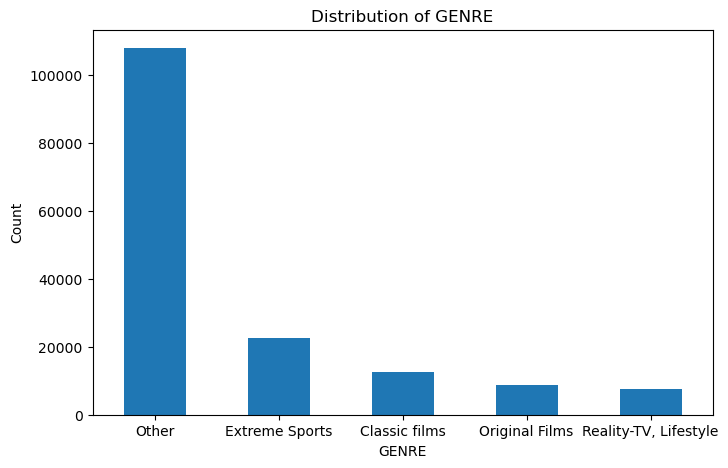

In [480]:
plt.figure(figsize=(8, 5))
view_xyz['GENRE'].value_counts().head(5).plot(kind='bar')

# Customize the plot
plt.title('Distribution of GENRE')
plt.xlabel('GENRE')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Show the plot
plt.show()

In [456]:
view_xyz['PROGRAM_NAME'].value_counts().head(20)

PROGRAM_NAME
Sugar Rush: Desserts on Deadline             2934
Master Butcher: Carving the Perfect Cut      2928
Food Truck Frenzy                            2896
The Chef Showdown: Battle of the Kitchens    2872
Bake Off Bonanza                             2866
Global Gourmet: Culinary Journeys            2858
Flavors of the World: Street Eats            2845
Farm to Table: The Chef’s Challenge          2822
Top Chef All-Stars: The Final Feast          2807
Spice Wars: The Heat is On                   2728
Modern Marvels: Futuristic Home Designs      2638
Renovation Rescue: Extreme Makeovers         2634
Budget Renovation: Luxe for Less             2630
Eco-Living: Sustainable Homes                2629
Curb Appeal: Outdoor Transformations         2619
Minimalist Dreams: Designing with Less       2618
Dream Spaces: Designer’s Pick                2604
Flip or Flop: The Ultimate Remodel           2601
Tiny Homes, Big Dreams                       2590
Entertainment Flash: The Week in Revi

In [462]:
grouped_df = view_xyz.groupby('PROGRAM_NAME', as_index=False)['DURATION_MINUTES'].sum()

# Sort by DURATION_MINUTES in descending order and take the top 50
grouped_df.sort_values(by='DURATION_MINUTES', ascending=False).head(50)

,PROGRAM_NAME,DURATION_MINUTES
70,Sugar Rush: Desserts on Deadline,167925.5
85,The Perfect Party Planner,167051.4
38,Food Truck Frenzy,166972.1
51,Master Butcher: Carving the Perfect Cut,166318.6
20,Destination Wedding Dreams,165563.1
76,The Chef Showdown: Battle of the Kitchens,165206.8
39,Global Gourmet: Culinary Journeys,164769.2
7,Behind the Glam: Celebrity Secrets,164452.0
35,Flavors of the World: Street Eats,163590.8
11,Celebrity Chefs Showdown,162027.4
